In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

Saving TrafficVolume_TrainingData.csv to TrafficVolume_TrainingData (1).csv


In [34]:
###--------- Import Datasets ---------###
dataset_train = pd.read_csv(io.BytesIO(uploaded['TrafficVolume_TrainingData.csv']))
training_set = dataset_train.iloc[:288, 2].values # Traffic volume column
                                                  # 2 because we want the TrafficVolume
                                                  # 288 because that gets all rows up until our last that has data
originalValues = training_set.copy()
# make training_set_scaled a pandas dataframe object
training_set = pd.DataFrame(training_set, columns = ['TrafficVolume'])
print(type(training_set))
# print(training_set)

###--------- Feature Scaling ---------###                                                  
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
training_set['TrafficVolume'] = scaler.fit_transform(training_set['TrafficVolume'].values.reshape(-1,1))

<class 'pandas.core.frame.DataFrame'>


In [35]:
def split_data(training_set, lookback):
    # data_raw = training_set_scaled.to_numpy() # convert to numpy array
    data_raw = training_set
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 24 # Lookback over the past 24 hours
x_train, y_train, x_test, y_test = split_data(training_set, lookback)

In [36]:
###--------- Setting Up PyTorch Model ---------###
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [37]:
# Define common values for both models regarding the layers
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [38]:
# Create a LTSM class for the LTSM model implementation
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [39]:
# We create the model, set the criterion, and the optimiser.
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model over 100 epochs
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [63]:
# Predict the traffic volume from our trained model
predictedValues = []

dataset_train = pd.read_csv(io.BytesIO(uploaded['TrafficVolume_TrainingData.csv']))
training_set = dataset_train.iloc[:288, 2].values # Traffic volume column
                                                  # 2 because we want the TrafficVolume
                                                  # 288 because that gets all rows up until our last that has data
# for i in range(288): # 288 Because we have 288 actual values here
# print(training_set[0])
predictions = model(x_train)
predictions = predictions.detach().numpy()
predictions = scaler.inverse_transform(predictions)
print(prediction)
  # predictedValues.append()

tensor([[-0.4805],
        [-0.7677],
        [-0.8625],
        [-0.9998],
        [-0.9456],
        [-0.8929],
        [-0.7978],
        [-0.4479],
        [-0.0032],
        [ 0.1737],
        [ 0.1251],
        [ 0.0972],
        [ 0.1302],
        [-0.0634],
        [-0.1506],
        [-0.2660],
        [-0.2460],
        [ 0.1860],
        [ 0.2320],
        [-0.1114],
        [-0.1068],
        [ 0.0541],
        [ 0.0935],
        [-0.0311],
        [-0.1882],
        [-0.6111],
        [-0.8264],
        [-0.9823],
        [-1.0102],
        [-0.9431],
        [-0.8420],
        [-0.5359],
        [-0.1008],
        [ 0.4023],
        [ 0.3858],
        [ 0.3319],
        [ 0.4082],
        [ 0.5101],
        [ 0.5865],
        [ 0.6728],
        [ 0.5859],
        [ 0.5033],
        [ 0.4619],
        [ 0.3649],
        [ 0.3390],
        [ 0.2552],
        [ 0.1626],
        [-0.1185],
        [-0.3444],
        [-0.7681],
        [-0.8647],
        [-1.0135],
        [-0.

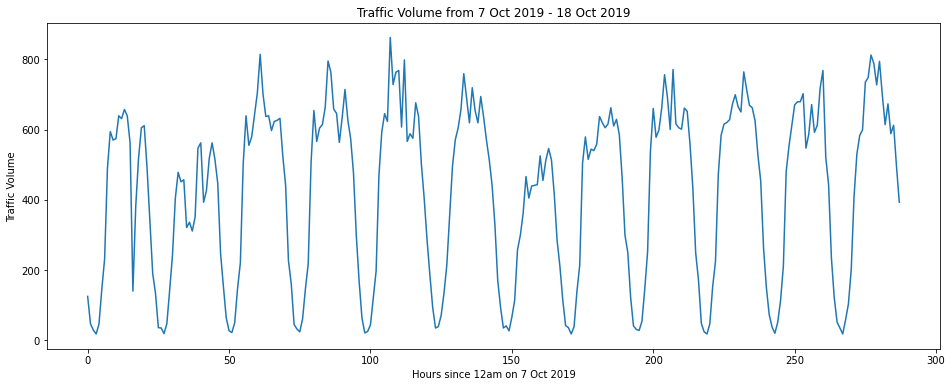

In [48]:
import matplotlib.pyplot as plt

# Make it bigger
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(6)
plt.plot(originalValues, label = "Actual")
plt.plot(predictedValues, label = "Predicted")
plt.title('Traffic Volume from 7 Oct 2019 - 18 Oct 2019')
plt.ylabel('Traffic Volume')
plt.xlabel('Hours since 12am on 7 Oct 2019')
plt.show()
